# Import

In [1]:
import os, sys
import joblib
import importlib
import holidays

import pandas as pd
import polars as pl
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import dproc, sgml, sgutil, sgpp

import lightgbm as lgb
import catboost as cb
import xgboost as xgb

print(sys.version)
for i in [pd, pl, mpl, sns, np, lgb, cb, xgb]:
    try:
        print(i.__name__, i.__version__)
    except:
        pass

3.12.6 (main, Sep 30 2024, 02:19:13) [GCC 9.4.0]
pandas 2.2.3
polars 1.12.0
matplotlib 3.8.4
seaborn 0.13.2
numpy 1.26.4
catboost 1.2.5
xgboost 2.1.2


In [2]:
from datetime import date


from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

from scipy.stats import chi2_contingency, pearsonr

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder 

In [3]:
from sklearn.base import TransformerMixin
class CountryEncoder(TransformerMixin):
    def __init__(self, gdp_file = 'gdp.csv'):
        self.gdp_file = gdp_file
        

    def fit(self, X, y = None):
        df_gdp = pd.read_csv(self.gdp_file)
        s_country = pd.Series(
                dict(zip(np.sort(X['country'].unique()), ["CA", "FI", "IT", "KE", "NO", "SG"]))
        )
        self.s_holiday = pd.concat([
            pd.Series(b, name = a).to_frame().unstack()
            for a, b in s_country.map(lambda x: holidays.country_holidays(x, years = range(2010, 2020))).items()
        ]).rename('holiday')
        
        self.s_gdp = df_gdp.loc[
            df_gdp.iloc[:, 0].isin(X['country'].unique())
        ].drop(columns = ['Code']).set_index('Country Name').loc[:, '2010':'2019'].rename(columns=lambda x: int(x)).stack().rename('gdp')
        self.features = X.columns.tolist()
        return self

    def transform(self, X):
        return X.assign(
            date = lambda x: x['date'].dt.date
        ).join(
            self.s_holiday, on = ['country', 'date']
        ).join(
            self.s_gdp, on = ['country', 'year'] 
        ).assign(
            holiday = lambda x: x['holiday'].fillna('None').astype('category')
        )

    def get_params(self, deep = True):
        return {}
        
    def set_output(self, transform = 'pandas'):
        pass

    def get_featrue_names_out(self, X = None):
        return self.features + ['holiday', 'gdp']

In [4]:
df_dt = pd.date_range('2010-01-01', '2020-12-31', freq = 'D').rename('date').to_frame().assign(
    days = lambda x: (x['date'] - x['date'].min()).dt.days,
    days_y1 = lambda x: x.groupby(x['date'].dt.year)['days'].transform(lambda x: x.rank() / len(x)),
    days_y2 = lambda x: x.groupby(x['date'].dt.year // 2)['days'].transform(lambda x: x.rank() / len(x)),
    c1 = lambda x: np.cos(x['days_y1'] * 2 * np.pi),
    s1 = lambda x: np.sin(x['days_y1'] * 2 * np.pi),
    c2 = lambda x: np.cos(x['days_y2'] * 2 * np.pi),
    s2 = lambda x: np.sin(x['days_y2'] * 2 * np.pi),
    c3 = lambda x: np.cos(x['days_y1'] * 4 * np.pi),
    s3 = lambda x: np.sin(x['days_y1'] * 4 * np.pi),
    c4 = lambda x: np.cos(x['days_y1'] * 8 * np.pi),
    s4 = lambda x: np.sin(x['days_y1'] * 8 * np.pi),
    date = lambda x: x['date'].dt.date,
).drop(columns = ['days', 'days_y1', 'days_y2']).set_index('date')

# Load Data

In [5]:
data_path = 'data'
files = {
    'train': os.path.join(data_path, 'train.csv'),
    'test': os.path.join(data_path, 'test.csv'),
    'vars': os.path.join(data_path, 'vars.pkl')
}
for i in ['result', 'data', 'model', 'img']:
    if not os.path.isdir(i):
        os.mkdir(i)

sc = sgutil.SGCache('img', 'result')

In [6]:
if (not os.path.isfile(files['train'])) and (not os.path.isfile(files['vars'])):
    !kaggle competitions download -c playground-series-s5e1
    if not os.path.exists(data_path):
        !mkdir data
    !unzip playground-series-s5e1.zip -d data
    !rm playground-series-s5e1.zip

In [7]:
min_dt = date(year = 2010, month = 1, day = 1)
t = sc.cache_result(
    'pl_pipeline',
    lambda : make_pipeline(
        sgpp.PolarsProcessor({'date': pl.Datetime}), 
        sgpp.ExprProcessor({
            'year':  pl.col('date').dt.year(),
            'month':  pl.col('date').dt.month(),
            'day':  pl.col('date').dt.day(),
            'weekday':  pl.col('date').dt.weekday(),
            'days': (pl.col('date') - min_dt).dt.total_days().cast(pl.Int16),
            'md': pl.col('date').dt.strftime('%m-%d').cast(pl.Categorical)
        }),
        sgpp.PandasCoverter(index_col = 'id'),
        CountryEncoder(),
        sgpp.JoinEncoder(df_dt, on = 'date')
    ).fit(files['train']), rerun = 1
)
df_train = t.transform(files['train'])
df_test = t.transform(files['test'])

In [8]:
df_train.isna().agg(['sum', 'mean'])

,date,country,store,product,num_sold,year,month,day,weekday,days,...,holiday,gdp,c1,s1,c2,s2,c3,s3,c4,s4
sum,0.0,0.0,0.0,0.0,8871.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.0,0.0,0.0,0.0,0.038548,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df_test.isna().agg(['sum', 'mean'])

,date,country,store,product,year,month,day,weekday,days,md,holiday,gdp,c1,s1,c2,s2,c3,s3,c4,s4
sum,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
df_train

,date,country,store,product,num_sold,year,month,day,weekday,days,...,holiday,gdp,c1,s1,c2,s2,c3,s3,c4,s4
id,,,,,,,,,,,,,,,,,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,2010,1,1,5,0,...,New Year's Day,1.617343e+12,0.999852,1.721336e-02,0.999963,0.008607,0.999407,3.442161e-02,0.99763,6.880243e-02
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,5,0,...,New Year's Day,1.617343e+12,0.999852,1.721336e-02,0.999963,0.008607,0.999407,3.442161e-02,0.99763,6.880243e-02
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,5,0,...,New Year's Day,1.617343e+12,0.999852,1.721336e-02,0.999963,0.008607,0.999407,3.442161e-02,0.99763,6.880243e-02
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,5,0,...,New Year's Day,1.617343e+12,0.999852,1.721336e-02,0.999963,0.008607,0.999407,3.442161e-02,0.99763,6.880243e-02
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,5,0,...,New Year's Day,1.617343e+12,0.999852,1.721336e-02,0.999963,0.008607,0.999407,3.442161e-02,0.99763,6.880243e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.0,2016,12,31,6,2556,...,None,3.187638e+11,1.000000,-2.449294e-16,-0.999991,-0.004298,1.000000,-4.898587e-16,1.00000,-9.797174e-16
230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.0,2016,12,31,6,2556,...,None,3.187638e+11,1.000000,-2.449294e-16,-0.999991,-0.004298,1.000000,-4.898587e-16,1.00000,-9.797174e-16
230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0,2016,12,31,6,2556,...,None,3.187638e+11,1.000000,-2.449294e-16,-0.999991,-0.004298,1.000000,-4.898587e-16,1.00000,-9.797174e-16


In [11]:
target = 'num_sold'
X_nom = ['country', 'store', 'product', 'weekday', 'month', 'md']
X_cat = X_nom
X_num = ['days', 'day']

In [12]:
df_train['date'].agg(['min', 'max']), df_test['date'].agg(['min', 'max'])

(min    2010-01-01
 max    2016-12-31
 Name: date, dtype: object,
 min    2017-01-01
 max    2019-12-31
 Name: date, dtype: object)

# Target

In [10]:
df_train[target].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
num_sold,221259.0,752.527405,690.165466,5.0,219.0,605.0,1114.0,5939.0


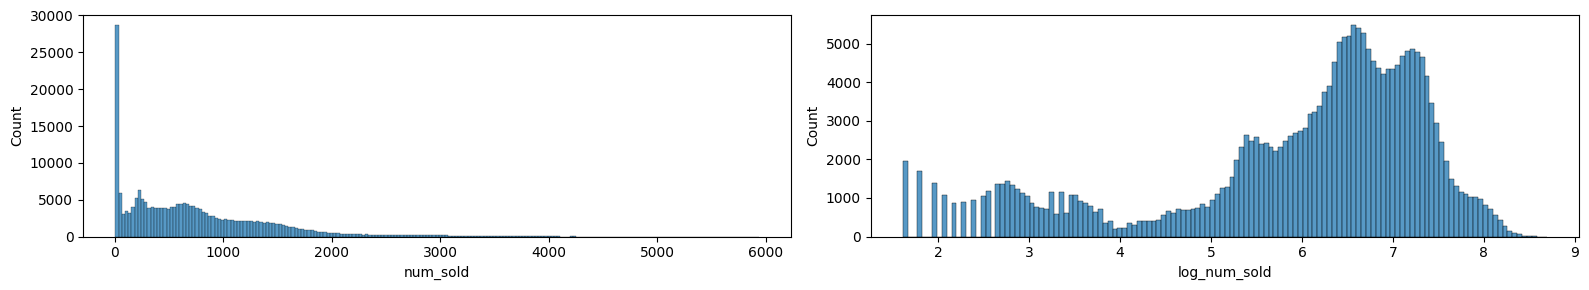

In [11]:
fig, axes = plt.subplots(1, 2, figsize = (16, 3))
sns.histplot(
    df_train[target] , ax = axes[0]
)

sns.histplot(
    np.log(df_train[target]).rename('log_num_sold') , ax = axes[1]
)
plt.tight_layout()
plt.show()

In [12]:
df_train['date'].value_counts().unique()

array([90])

In [13]:
df_train.groupby('date')[target].agg(lambda x: x.isna().sum()).rename('na_cnt_by_date').value_counts().rename('count of na_cnt_by_date').to_frame().T

na_cnt_by_date,3,2,4,5,6,7
count of na_cnt_by_date,748,679,534,447,145,4


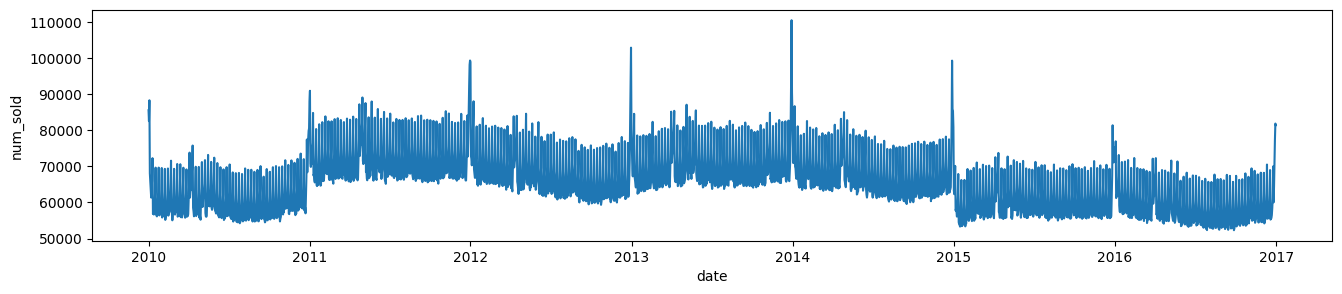

In [14]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(
    df_train.groupby('date')[target].agg(lambda x: x.sort_values(ascending = False).iloc[:-6].sum())
)
plt.show()

# Categorical Variables

In [15]:
df_train[X_cat].apply(lambda x: x.nunique()).rename('nunique').to_frame().T

,country,store,product,weekday,month,md,y_8,y_2
nunique,6,3,5,7,12,366,2,2


In [16]:
for i in X_cat:
    display(df_train[i].value_counts().to_frame().T)

country,Canada,Finland,Italy,Kenya,Norway,Singapore
count,38355,38355,38355,38355,38355,38355


store,Discount Stickers,Stickers for Less,Premium Sticker Mart
count,76710,76710,76710


product,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode
count,46026,46026,46026,46026,46026


weekday,5,6,7,1,2,3,4
count,32940,32940,32850,32850,32850,32850,32850


month,1,3,5,7,8,10,12,4,6,9,11,2
count,19530,19530,19530,19530,19530,19530,19530,18900,18900,18900,18900,17820


md,01-01,09-09,09-07,09-06,09-05,09-04,09-03,09-02,09-01,08-31,...,04-27,05-05,05-04,05-03,05-02,05-01,04-30,04-29,04-28,02-29
count,630,630,630,630,630,630,630,630,630,630,...,630,630,630,630,630,630,630,630,630,180


y_8,True,False
count,131490,98640


y_2,0,1
count,131580,98550


# Imputing NA in num_sold

In [17]:
df_train[X_cat].apply(
    lambda x: chi2_contingency(pd.crosstab(index = x, columns = df_train[target].isna())).pvalue
)

country    0.000000e+00
store      0.000000e+00
product    0.000000e+00
weekday    8.483659e-44
month      6.909299e-79
md         3.966093e-04
y_8        3.826558e-10
y_2        2.092241e-01
dtype: float64

In [18]:
pd.crosstab(index = df_train['country'], columns = df_train[target].isna()).T

country,Canada,Finland,Italy,Kenya,Norway,Singapore
num_sold,,,,,,
False,34109,38355,38355,33730,38355,38355
True,4246,0,0,4625,0,0


In [19]:
pd.crosstab(index = df_train['product'], columns = df_train[target].isna()).T

product,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode
num_sold,,,,,
False,37220,46026,46026,45962,46025
True,8806,0,0,64,1


In [20]:
pd.crosstab(index = df_train['store'], columns = df_train[target].isna()).T

store,Discount Stickers,Stickers for Less,Premium Sticker Mart
num_sold,,,
False,71531,74044,75684
True,5179,2666,1026


In [21]:
df_train.loc[(df_train['country'] == 'Canada') & (df_train[target].isna()), ['store', 'product']].value_counts()

store                 product          
Discount Stickers     Holographic Goose    2557
Stickers for Less     Holographic Goose    1308
Premium Sticker Mart  Holographic Goose     380
Discount Stickers     Kerneler                1
Name: count, dtype: int64

In [22]:
df_train.loc[(df_train['country'] == 'Kenya') & (df_train[target].isna()), ['store', 'product']].value_counts()

store                 product           
Discount Stickers     Holographic Goose     2557
Stickers for Less     Holographic Goose     1358
Premium Sticker Mart  Holographic Goose      646
Discount Stickers     Kerneler                63
                      Kerneler Dark Mode       1
Name: count, dtype: int64

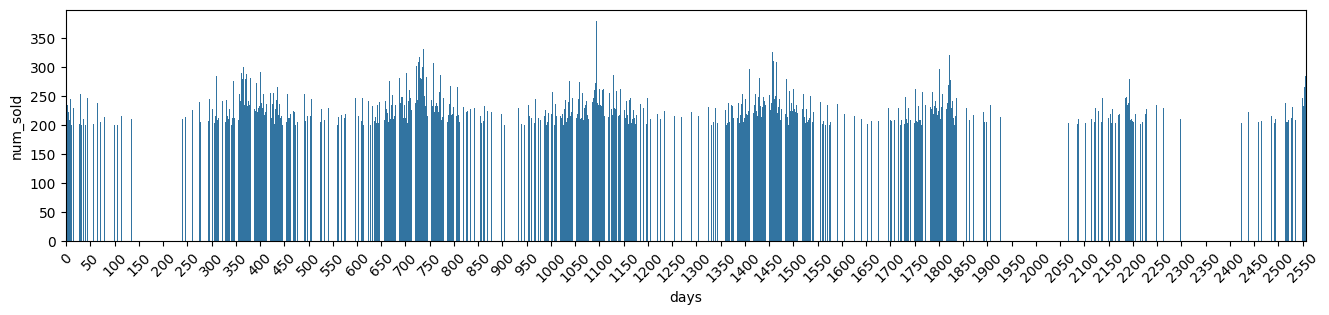

In [23]:
plt.figure(figsize = (16, 3))
sns.barplot(
    df_train.loc[(df_train['country'].isin(['Canada'])) & (df_train['product'] == "Holographic Goose") & (df_train['store'] == "Stickers for Less")],
    x = 'days', y = target
)
xticks = plt.gca().get_xticks() 
xtick_labels = plt.gca().get_xticklabels()  # 현재 x축 레이블 가져오기
# 일부 레이블만 표시
plt.xticks(xticks[::50], [label.get_text() for label in xtick_labels][::50], rotation=45) 
plt.show()

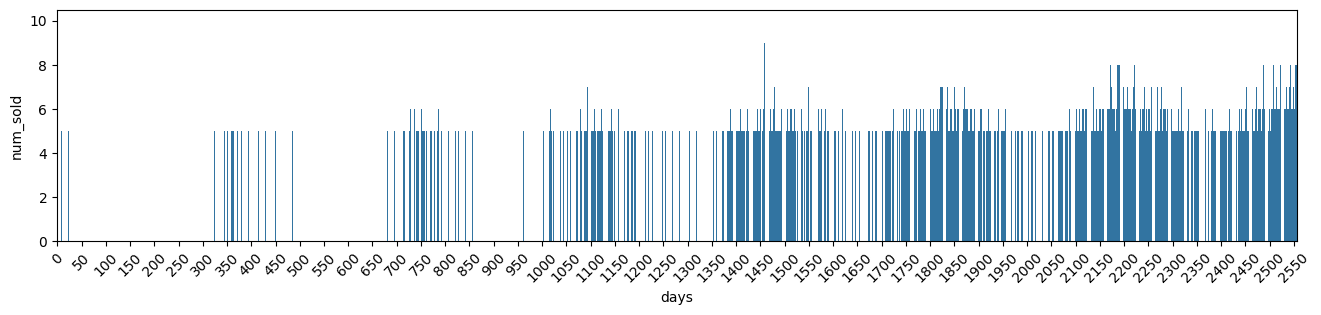

In [24]:
plt.figure(figsize = (16, 3))
sns.barplot(
    df_train.loc[(df_train['country'].isin(['Kenya'])) & (df_train['product'] == "Holographic Goose") & (df_train['store'] == "Stickers for Less")],
    x = 'days', y = target
)
xticks = plt.gca().get_xticks() 
xtick_labels = plt.gca().get_xticklabels()  # 현재 x축 레이블 가져오기
# 일부 레이블만 표시
plt.xticks(xticks[::50], [label.get_text() for label in xtick_labels][::50], rotation=45) 
plt.show()

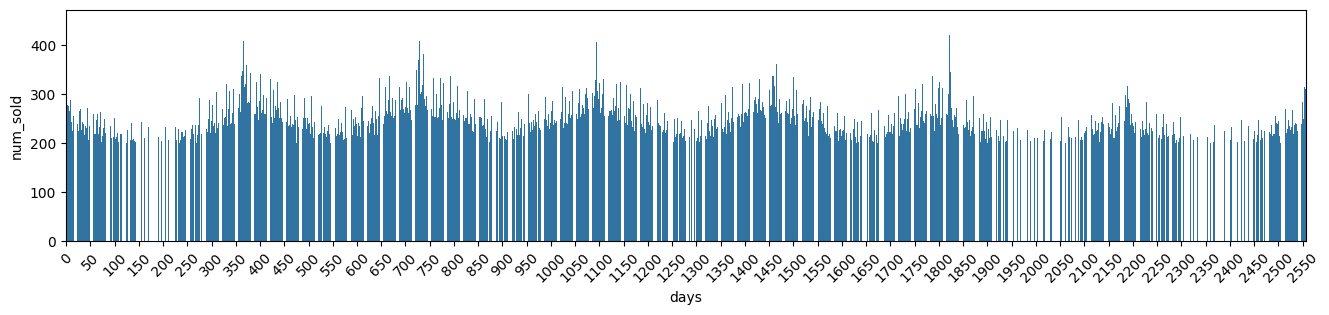

In [25]:
plt.figure(figsize = (16, 3))
sns.barplot(
    df_train.loc[(df_train['country'].isin(['Canada'])) & (df_train['product'] == "Holographic Goose") & (df_train['store'] == "Premium Sticker Mart")],
    x = 'days', y = target
)
xticks = plt.gca().get_xticks() 
xtick_labels = plt.gca().get_xticklabels()  # 현재 x축 레이블 가져오기
# 일부 레이블만 표시
plt.xticks(xticks[::50], [label.get_text() for label in xtick_labels][::50], rotation=45) 
plt.show()

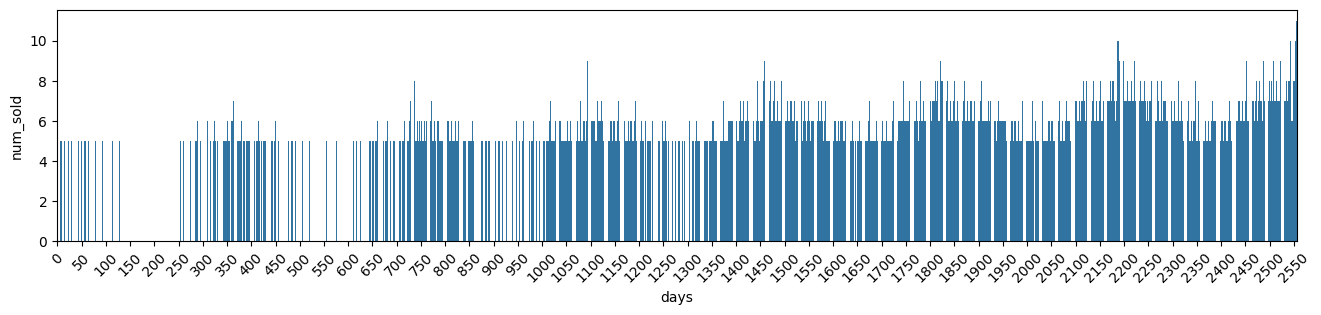

In [26]:
plt.figure(figsize = (16, 3))
sns.barplot(
    df_train.loc[(df_train['country'].isin(['Kenya'])) & (df_train['product'] == "Holographic Goose") & (df_train['store'] == "Premium Sticker Mart")],
    x = 'days', y = target
)
xticks = plt.gca().get_xticks() 
xtick_labels = plt.gca().get_xticklabels()  # 현재 x축 레이블 가져오기
# 일부 레이블만 표시
plt.xticks(xticks[::50], [label.get_text() for label in xtick_labels][::50], rotation=45) 
plt.show()

In [27]:
df_train.loc[(df_train['product'] == 'Kerneler Dark Mode') & df_train[target].isna()]

,date,country,store,product,num_sold,year,month,day,weekday,days,y_8,y_2,md
id,,,,,,,,,,,,,
23719,2010-09-21,Kenya,Discount Stickers,Kerneler Dark Mode,NaN,2010,9,21,2,263,False,0,09-21


In [28]:
df_train.loc[(df_train['product'] == 'Kerneler Dark Mode') & (df_train['country'] == 'Kenya') & df_train['days'].isin([262, 264])]

,date,country,store,product,num_sold,year,month,day,weekday,days,y_8,y_2,md
id,,,,,,,,,,,,,
23629,2010-09-20,Kenya,Discount Stickers,Kerneler Dark Mode,5.0,2010,9,20,1,262,False,0,09-20
23634,2010-09-20,Kenya,Stickers for Less,Kerneler Dark Mode,10.0,2010,9,20,1,262,False,0,09-20
23639,2010-09-20,Kenya,Premium Sticker Mart,Kerneler Dark Mode,13.0,2010,9,20,1,262,False,0,09-20
23809,2010-09-22,Kenya,Discount Stickers,Kerneler Dark Mode,5.0,2010,9,22,3,264,False,0,09-22
23814,2010-09-22,Kenya,Stickers for Less,Kerneler Dark Mode,11.0,2010,9,22,3,264,False,0,09-22
23819,2010-09-22,Kenya,Premium Sticker Mart,Kerneler Dark Mode,13.0,2010,9,22,3,264,False,0,09-22


In [29]:
df_train.loc[df_train['product'] == 'Kerneler Dark Mode', target] = df_train.loc[df_train['product'] == 'Kerneler Dark Mode', target].fillna(5)
df_train.loc[(df_train['product'] == 'Kerneler'), target] = \
    df_train.loc[(df_train['product'] == 'Kerneler')].groupby(['country', 'store'], observed = False)[target].transform(
        lambda x: x.interpolate()
    )

In [30]:
df_train.groupby('date')[target].agg(lambda x: x.isna().sum()).rename('na_cnt_by_date').value_counts().rename('count of na_cnt_by_date').to_frame().T

na_cnt_by_date,3,2,4,5,6
count of na_cnt_by_date,751,679,547,473,107


In [31]:
df_train.loc[df_train['product'] != 'Holographic Goose', target].isna().sum()

0

In [32]:
df_train.loc[~df_train['country'].isin(['Canada', 'Kenya']), target].isna().sum()

0

In [33]:
df_ratio_product = df_train.loc[~df_train['country'].isin(['Canada', 'Kenya'])].pipe(
    lambda x: x.pivot_table(index = x['days'], columns = x['product'], values=target, aggfunc = 'sum', observed = True)
).pipe(
    lambda x: x.divide(x.sum(axis=1), axis = 0)
)
df_ratio_product.head()

product,Holographic Goose,Kaggle,Kaggle Tiers,Kerneler,Kerneler Dark Mode
days,,,,,
0,0.052199,0.329210,0.289181,0.154402,0.175008
1,0.051393,0.331010,0.290622,0.148871,0.178105
2,0.051953,0.332878,0.289431,0.150612,0.175125
3,0.052749,0.325723,0.297911,0.146376,0.177240
4,0.051869,0.329591,0.290967,0.147771,0.179801


In [34]:
df_ratio_country = df_train.loc[df_train['product'] != 'Holographic Goose'].pipe(
    lambda x: x.pivot_table(index = x['days'], columns = x['country'], values=target, aggfunc = 'sum', observed = True)
).pipe(
    lambda x: x.divide(x.sum(axis=1), axis = 0)
)
df_ratio_country.head()

country,Canada,Finland,Italy,Kenya,Norway,Singapore
days,,,,,,
0,0.177600,0.178992,0.135909,0.003460,0.325773,0.178265
1,0.181301,0.173870,0.131336,0.003505,0.328672,0.181314
2,0.178494,0.175288,0.135738,0.003468,0.328460,0.178553
3,0.175085,0.174729,0.133957,0.003514,0.334303,0.178413
4,0.175983,0.177955,0.139273,0.003543,0.326975,0.176272


In [35]:
df_ratio_store = df_train.loc[(df_train['product'] != 'Holographic Goose') & ~df_train['country'].isin(['Canada', 'Kenya'])].pipe(
    lambda x: x.pivot_table(index = x['days'], columns = x['store'], values=target, aggfunc = 'sum', observed = True)
).pipe(
    lambda x: x.divide(x.sum(axis=1), axis = 0)
)
df_ratio_store.head()

store,Discount Stickers,Stickers for Less,Premium Sticker Mart
days,,,
0,0.182737,0.373427,0.443836
1,0.185237,0.373569,0.441194
2,0.185028,0.359058,0.455913
3,0.182531,0.375596,0.441873
4,0.185612,0.380036,0.434352


In [36]:
df_ratio = pd.DataFrame(
    0,
    columns = pd.MultiIndex.from_product(df_train[X_cat[:3]].apply(lambda x: x.unique().tolist())),
    index = df_train['days'].unique()
).apply(
    lambda x: df_ratio_country.loc[:, x.name[0]] * df_ratio_store.loc[:, x.name[1]] * df_ratio_product.loc[:, x.name[2]]
)
df_ratio.head()

Canada                                                      \
     Discount Stickers                                                       
     Holographic Goose    Kaggle Kaggle Tiers  Kerneler Kerneler Dark Mode   
days                                                                         
0             0.001694  0.010684     0.009385  0.005011           0.005680   
1             0.001726  0.011117     0.009760  0.005000           0.005981   
2             0.001716  0.010994     0.009559  0.004974           0.005784   
3             0.001686  0.010410     0.009521  0.004678           0.005664   
4             0.001694  0.010766     0.009504  0.004827           0.005873   

                                                                            \
     Stickers for Less                                                       
     Holographic Goose    Kaggle Kaggle Tiers  Kerneler Kerneler Dark Mode   
days                                                                         
0             0.003462  0.021833     0.019179  0.010240           0.011607   
1             0.003481  0.022419     0.019683  0.010083           0.012063   
2             0.003330  0.021334     0.018550  0.009653           0.011224   
3             0.003469  0.021420     0.019591  0.009626           0.011656   
4             0.003469  0.022043     0.019460  0.009883           0.012025   

      ...         Singapore                                   \
      ... Stickers for Less                                    
      ... Holographic Goose    Kaggle Kaggle Tiers  Kerneler   
days  ...                                                      
0     ...          0.003475  0.021915     0.019251  0.010278   
1     ...          0.003481  0.022420     0.019685  0.010084   
2     ...          0.003331  0.021341     0.018556  0.009656   
3     ...          0.003535  0.021827     0.019963  0.009809   
4     ...          0.003475  0.022079     0.019492  0.009899   

                                                                               \
                        Premium Sticker Mart                                    
     Kerneler Dark Mode    Holographic Goose    Kaggle Kaggle Tiers  Kerneler   
days                                                                            
0              0.011650             0.004130  0.026047     0.022880  0.012216   
1              0.012064             0.004111  0.026479     0.023248  0.011909   
2              0.011227             0.004229  0.027098     0.023561  0.012261   
3              0.011877             0.004159  0.025679     0.023486  0.011540   
4              0.012045             0.003971  0.025235     0.022278  0.011314   

                         
                         
     Kerneler Dark Mode  
days                     
0              0.013847  
1              0.014247  
2              0.014256  
3              0.013973  
4              0.013766  

[5 rows x 90 columns]

In [37]:
df_ratio_notna = pd.DataFrame(
    df_ratio.values * df_train.assign(target_notna = lambda x: x[target].notna()).pivot(
        index = 'days', columns = X_cat[:3], values = 'target_notna'
    ).values, index = df_ratio.index, columns = df_ratio.columns
)
df_ratio_notna.head()

Canada                                                      \
     Discount Stickers                                                       
     Holographic Goose    Kaggle Kaggle Tiers  Kerneler Kerneler Dark Mode   
days                                                                         
0                  0.0  0.010684     0.009385  0.005011           0.005680   
1                  0.0  0.011117     0.009760  0.005000           0.005981   
2                  0.0  0.010994     0.009559  0.004974           0.005784   
3                  0.0  0.010410     0.009521  0.004678           0.005664   
4                  0.0  0.010766     0.009504  0.004827           0.005873   

                                                                            \
     Stickers for Less                                                       
     Holographic Goose    Kaggle Kaggle Tiers  Kerneler Kerneler Dark Mode   
days                                                                         
0             0.003462  0.021833     0.019179  0.010240           0.011607   
1             0.003481  0.022419     0.019683  0.010083           0.012063   
2             0.003330  0.021334     0.018550  0.009653           0.011224   
3             0.003469  0.021420     0.019591  0.009626           0.011656   
4             0.003469  0.022043     0.019460  0.009883           0.012025   

      ...         Singapore                                   \
      ... Stickers for Less                                    
      ... Holographic Goose    Kaggle Kaggle Tiers  Kerneler   
days  ...                                                      
0     ...          0.003475  0.021915     0.019251  0.010278   
1     ...          0.003481  0.022420     0.019685  0.010084   
2     ...          0.003331  0.021341     0.018556  0.009656   
3     ...          0.003535  0.021827     0.019963  0.009809   
4     ...          0.003475  0.022079     0.019492  0.009899   

                                                                               \
                        Premium Sticker Mart                                    
     Kerneler Dark Mode    Holographic Goose    Kaggle Kaggle Tiers  Kerneler   
days                                                                            
0              0.011650             0.004130  0.026047     0.022880  0.012216   
1              0.012064             0.004111  0.026479     0.023248  0.011909   
2              0.011227             0.004229  0.027098     0.023561  0.012261   
3              0.011877             0.004159  0.025679     0.023486  0.011540   
4              0.012045             0.003971  0.025235     0.022278  0.011314   

                         
                         
     Kerneler Dark Mode  
days                     
0              0.013847  
1              0.014247  
2              0.014256  
3              0.013973  
4              0.013766  

[5 rows x 90 columns]

In [38]:
s_est_daily_sum = df_train.groupby('days')[target].sum() * 1 / df_ratio_notna.sum(axis = 1)
s_est_daily_sum.head()

days
0    85714.031250
1    82693.492188
2    88482.773438
3    68197.023438
4    65831.382812
dtype: float32

In [39]:
df_train.loc[df_train[target].isna(), target] = df_train.loc[df_train[target].isna()].apply(
    lambda x: df_ratio.loc[x['days'], tuple(x[X_cat[:3]])] * s_est_daily_sum.loc[x['days']], axis = 1
)

In [40]:
df_train[target].isna().sum()

0

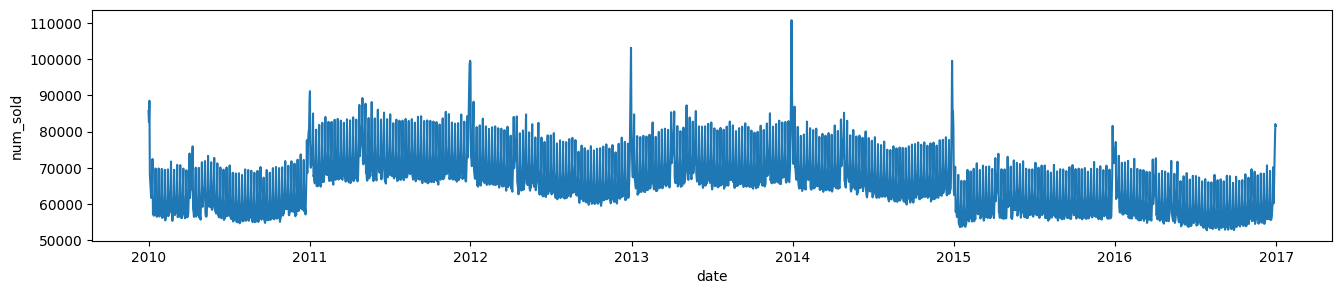

In [41]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(
    df_train.groupby('date')[target].sum()
)
plt.show()

In [ ]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(
    df_train.groupby(['date', 'country'], as_index = False, observed=False)[target].sum(), 
    x = 'date', y = 'num_sold', hue = 'country'
)
plt.show()

In [ ]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(
    df_train.groupby(['date', 'store'], as_index = False, observed=False)[target].sum(), 
    x = 'date', y = 'num_sold', hue = 'store'
)
plt.show()

In [ ]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(
    df_train.groupby(['date', 'product'], as_index = False, observed=False)[target].sum(), 
    x = 'date', y = 'num_sold', hue = 'product'
)
plt.show()

# Reformulation Problem

In [ ]:
df_re = df_train[['days', 'date', 'year', 'month', 'day', 'weekday']].drop_duplicates().set_index('days').join(
    s_est_daily_sum.rename('est_sum')
).assign(
    y_days = lambda x: x['date'].dt.dayofyear,
    est_y_mc = lambda x: x['est_sum'] - x.groupby('year')['est_sum'].transform(lambda x: x.clip(*x.quantile([0.025, 0.975])).mean()),
    est_yw_mc = lambda x: x['est_y_mc'] - x.groupby('weekday')['est_y_mc'].transform(lambda x: x.clip(*x.quantile([0.025, 0.975])).mean()),
    md = lambda x: x['date'].dt.strftime('%m-%d'),
    est_ywd_mc = lambda x: x['est_yw_mc'] - x.groupby(['md'], observed = True)['est_yw_mc'].transform('mean')
)

In [ ]:
fig, axes = plt.subplots(3, 1, figsize = (16, 7))
sns.lineplot(df_re['est_y_mc'], ax = axes[0])
sns.lineplot(df_re['est_yw_mc'], ax = axes[1])
sns.lineplot(df_re['est_ywd_mc'], ax = axes[2])
plt.tight_layout()
plt.show()

In [ ]:
def get_freq_mag(t, data):
    # FFT 수행
    fft_result = np.fft.fft(data)  # 복소수 결과 반환
    frequencies = np.fft.fftfreq(len(t), d=(t[1] - t[0]))  # 주파수 계산
    
    # 절대값(진폭) 계산
    magnitude = np.abs(fft_result)
    
    # 양의 주파수만 고려 (대칭 구조이므로)
    positive_frequencies = frequencies[frequencies > 0]
    positive_magnitude = magnitude[frequencies > 0]
    
    # 주기 계산
    periods = 1 / positive_frequencies
    return periods, positive_magnitude

periods, positive_magnitude = get_freq_mag(df_re.index.values, df_re['est_ywd_mc'].values)
# 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# 원 데이터
axes[0].plot(df_re.index.values, df_re['est_ywd_mc'].values, label="Original Data")
axes[0].set_title("Original Time Series Data")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
axes[0].legend()

# 주파수 성분
axes[1].plot(periods, positive_magnitude, label="FFT Magnitude")
axes[1].set_title("Frequency Domain Analysis (FFT)")
axes[1].set_xlabel("Period (1/Frequency)")
axes[1].set_ylabel("Magnitude")
axes[1].set_xscale("log")
axes[1].legend()

plt.tight_layout()
plt.show()

# 주요 주기 출력
peak_indices = np.argsort(positive_magnitude)[-3:][::-1]  # 상위 3개 추출
print("Top 3 periods with highest magnitude:")
for idx in peak_indices:
    print(f"Period: {periods[idx]:.2f}, Magnitude: {positive_magnitude[idx]:.2f}")

In [ ]:
df_re['c1'] = np.cos((df_re.index / 365.25) * np.pi)
df_re['s1'] = np.sin((df_re.index / 365.25) * np.pi)

In [ ]:
from scipy.stats import pearsonr
(
    pearsonr(df_re['c1'], df_re['est_ywd_mc']),
    pearsonr(df_re['s1'], df_re['est_ywd_mc']),
    pearsonr(df_re.index, df_re['est_ywd_mc'])
)

In [ ]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), ['month', 'md']),
    ('pt', 'passthrough', ['c1', 's1'])
])
reg_lr = make_pipeline(ct, LinearRegression())
reg_lr.fit(df_re[['c1', 's1', 'month', 'md']], df_re['est_ywd_mc'])

In [ ]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(reg_lr.predict(df_re[['c1', 's1', 'month', 'md']]))
plt.show()

In [ ]:
s_y = df_re.groupby('year')['est_sum'].mean()
s_y

In [ ]:
s_weekday = df_re.groupby('weekday')['est_y_mc'].mean()
s_md = df_re.groupby('md')['est_yw_mc'].mean()

In [ ]:
df_re = df_re.assign(
    est_y = s_y.mean(),
    est_w = lambda x: x['weekday'].map(s_weekday), 
    md = lambda x: x['date'].dt.strftime('%m-%d'),
    est_md = lambda x: x['md'].map(s_md),
    est_days = lambda x: reg_lr.predict(x[['c1', 's1', 'month', 'md']]),
    est_sum_prd = lambda x: x['est_y'] + x['est_w'] + x['est_md'] + x['est_days']
)

In [ ]:
s_yt = pd.Series({2017: 60000, 2018: 60000, 2019: 72000})

In [ ]:
df_re_test = df_test[['days', 'date', 'year', 'month', 'day', 'weekday']].drop_duplicates().set_index('days').assign(
    c1 = lambda x: np.cos((x.index / 365.25) * np.pi),
    s1 = lambda x: np.sin((x.index / 365.25) * np.pi),
    est_y = lambda x: x['year'].map(s_yt), 
    est_w = lambda x: x['weekday'].map(s_weekday), 
    md = lambda x: x['date'].dt.strftime('%m-%d'),
    est_md = lambda x: x['md'].map(s_md),
    est_days = lambda x: reg_lr.predict(x[['c1', 's1', 'month', 'md']]),
    est_sum = lambda x: x['est_y'] + x['est_w'] + x['est_md'] + x['est_days']
)

In [ ]:
fig = plt.figure(figsize = (16, 3))
plt.plot(df_re.index, df_re['est_sum'], label='train')
plt.plot(df_re_test.index, df_re_test['est_sum'], label='test')
plt.legend()
plt.show()

In [ ]:
df_ratio.apply(
    lambda x: pearsonr(x, x.index)
)

In [ ]:
periods, positive_magnitude = get_freq_mag(df_ratio_country.index, df_ratio_country['Canada'])

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# 원 데이터
axes[0].plot(df_ratio_country.index, df_ratio_country['Canada'], label="Original Data")
axes[0].set_title("Original Time Series Data")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
axes[0].legend()

# 주파수 성분
axes[1].plot(periods, positive_magnitude, label="FFT Magnitude")
axes[1].set_title("Frequency Domain Analysis (FFT)")
axes[1].set_xlabel("Period (1/Frequency)")
axes[1].set_ylabel("Magnitude")
axes[1].set_xscale("log")
axes[1].legend()

print(periods[np.argmax(positive_magnitude)])
plt.tight_layout()
plt.show()

In [ ]:
df_ratio_country.apply(
    lambda x: get_freq_mag(x.index, x)
).apply(
    lambda x: [x[0][np.argmax(x[1])], np.max(x[1])]
    , axis = 0
)

In [ ]:
df_ratio_store.apply(
    lambda x: get_freq_mag(x.index, x)
).apply(
    lambda x: [x[0][np.argmax(x[1])], np.max(x[1])]
    , axis = 0
)

In [ ]:
df_ratio_product.apply(
    lambda x: get_freq_mag(x.index, x)
).apply(
    lambda x: [x[0][np.argmax(x[1])], np.max(x[1])]
    , axis = 0
)

In [ ]:
df_ratio_country.apply(
    lambda x: pearsonr(x.index, x)
)

In [ ]:
df_ratio_store.apply(
    lambda x: pearsonr(x.index, x)
)

In [ ]:
df_ratio_product.apply(
    lambda x: pearsonr(x.index, x)
)

In [ ]:
products = df_train['product'].unique()
df_dr = df_train.assign(
    ratio = lambda x: x['num_sold'] / x.groupby('days')['num_sold'].transform('sum'),
    md = lambda x: x['date'].dt.strftime('%m-%d'),
    logit = lambda x: np.log(x['ratio'] / (1 - x['ratio'])),
    c1 = lambda x: np.cos((x['days'] / 365.25 * 2) * np.pi),
    s1 = lambda x: np.sin((x['days'] / 365.25 * 2) * np.pi),
    c2 = lambda x: np.cos((x['days'] / 365.25) * np.pi),
    s2 = lambda x: np.sin((x['days'] / 365.25) * np.pi),
    y_days = lambda x: x['date'].dt.dayofyear,
).pipe(
    lambda x: pd.concat([x]
        + [(x['c1'] * (x['product'] == i)).rename('c1_{}'.format(i)) for i in products]
        + [(x['s1'] * (x['product'] == i)).rename('s1_{}'.format(i)) for i in products]
        + [(x['c2'] * (x['product'] == i)).rename('c2_{}'.format(i)) for i in products]
        + [(x['s2'] * (x['product'] == i)).rename('s2_{}'.format(i)) for i in products]
        + [(x['days'] * (x['country'] == i)).rename('d_{}'.format(i)) for i in df_train['country'].unique()]
    , axis=1)
)

In [ ]:
X_cs = ['c1_{}'.format(i) for i in products] + \
    ['s1_{}'.format(i) for i in products] + \
    ['c2_{}'.format(i) for i in products] + \
    ['s2_{}'.format(i) for i in products]
X_d = ['d_{}'.format(i) for i in df_train['country'].unique()]

In [ ]:
df_dr_train = df_dr.loc[df_dr['year'] < 2016]
df_dr_test = df_dr.loc[df_dr['year'] >= 2016]

df_dr_re = df_dr_train[['days', 'date', 'year', 'month', 'day', 'weekday']].drop_duplicates().set_index('days').join(
    s_est_daily_sum.rename('est_sum')
).assign(
    est_y_mc = lambda x: x['est_sum'] - x.groupby('year')['est_sum'].transform('mean'),
    est_yw_mc = lambda x: x['est_y_mc'] - x.groupby('weekday')['est_y_mc'].transform('mean'),
    md = lambda x: x['date'].dt.strftime('%m-%d'),
    est_ywd_mc = lambda x: x['est_yw_mc'] - x.groupby('md')['est_yw_mc'].transform('mean'),
    c1 = lambda x: np.cos((x.index / 365.25) * np.pi),
    s1 = lambda x: np.sin((x.index / 365.25) * np.pi),
)

s_weekday = df_dr_re.groupby('weekday')['est_y_mc'].mean()
s_md = df_dr_re.groupby('md')['est_yw_mc'].mean()
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), ['month']),
    ('pt', 'passthrough', ['c1', 's1'])
])
reg_lr_est = make_pipeline(ct, LinearRegression())
reg_lr_est.fit(df_dr_re[['c1', 's1', 'month', 'md']], df_dr_re['est_ywd_mc'])
df_dr_re_test = df_dr_test[['days', 'date', 'year', 'month', 'day', 'weekday']].drop_duplicates().set_index('days').join(
    s_est_daily_sum.rename('est_sum')
).assign(
    c1 = lambda x: np.cos((x.index / 365.25) * np.pi),
    s1 = lambda x: np.sin((x.index / 365.25) * np.pi),
    est_y = 60000, 
    est_w = lambda x: x['weekday'].map(s_weekday), 
    md = lambda x: x['date'].dt.strftime('%m-%d'),
    est_md = lambda x: x['md'].map(s_md),
    est_days = lambda x: reg_lr_est.predict(x[['c1', 's1', 'month']]),
    est_sum_prd = lambda x: x['est_y'] + x['est_w'] + x['est_md'] + x['est_days']
)

df_dr_train = df_dr_train.join(df_dr_re['est_sum'], on = 'days')
df_dr_test = df_dr_test.join(df_dr_re_test[['est_sum', 'est_sum_prd']], on = 'days')

In [ ]:
X_all = ['country', 'store', 'product', 'weekday', 'md', 'month', 'days'] + X_cs + X_d
def eval_model(model, fit_params = {}):
    model.fit(df_dr_train[X_all], df_dr_train['logit'], **fit_params)
    prd = model.predict(df_dr_test[X_all])
    prd_train = model.predict(df_dr_train[X_all])
    print(
        r2_score(df_dr_test['logit'], prd),
        r2_score(df_dr_train['logit'], prd_train),
        mean_absolute_percentage_error(
            df_dr_test['num_sold'], 1 / (1 + np.exp(-prd)) * df_dr_test['est_sum_prd']
        ),
        mean_absolute_percentage_error(
            df_dr_train['num_sold'], 1 / (1 + np.exp(-prd_train)) * df_dr_train['est_sum']
        )
    )
    return pd.Series(prd, index = df_dr_test.index)

In [ ]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='first'), ['country', 'store', 'product', 'weekday', 'md', 'month']),
    ('mm', MinMaxScaler(), X_d + ['days']),
    ('pt', 'passthrough', X_cs)
])
reg_lr = make_pipeline(ct, LinearRegression())
lr_prd = eval_model(reg_lr).rename('lr')

In [ ]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary'), ['country', 'store', 'product', 'weekday', 'md', 'month']),
    ('pt', 'passthrough', X_cs + X_d )
])
reg_lgb = make_pipeline(ct, lgb.LGBMRegressor(verbose = -1, num_leaves=7, n_estimators=3000, learning_rate=0.1))
lgb_prd = eval_model(reg_lgb).rename('lgb')

In [ ]:
df_tmp = df_dr_test.join(
    ((1 / (1 + np.exp(-lgb_prd))) * df_dr_test['est_sum_prd']).rename('prd')
)

In [ ]:
fig = plt.figure(figsize = (16, 3))
sns.lineplot(
    df_tmp.groupby(['date', 'product'], as_index = False, observed=False)['prd'].sum(), 
    x = 'date', y = 'prd', hue = 'product'
)
plt.show()

In [ ]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary'), ['country', 'store', 'product', 'weekday', 'md', 'month']),
    ('pt', 'passthrough', X_cs + X_d)
])
reg_lgb2 = make_pipeline(ct, lgb.LGBMRegressor(verbose = -1, num_leaves=15, n_estimators=3000, learning_rate=0.1))
lgb_prd2 = eval_model(reg_lgb2).rename('lgb2')

In [ ]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary'), ['country', 'store', 'product', 'weekday', 'md', 'month']),
    ('pt', 'passthrough', X_cs + X_d)
])
reg_xgb = make_pipeline(ct, xgb.XGBRegressor(max_depth=3, n_estimators=2500, learning_rate = 0.05))
xgb_prd = eval_model(reg_xgb).rename('xgb')

In [ ]:
ct = ColumnTransformer([
    ('ohe', OneHotEncoder(drop='if_binary'), ['country', 'store', 'product', 'weekday', 'md', 'month']),
    ('pt', 'passthrough', X_cs + X_d)
])
reg_xgb2 = make_pipeline(ct, xgb.XGBRegressor(max_depth=2, n_estimators=2500, learning_rate = 0.05))
xgb_prd2 = eval_model(reg_xgb2).rename('xgb2')

In [ ]:
ct = ColumnTransformer([
    ('pt', 'passthrough', ['country', 'store', 'product', 'weekday', 'md', 'month', 'year'] +  X_cs + X_d),
]).set_output(transform='pandas')
reg_cb = make_pipeline(ct, cb.CatBoostRegressor(
    max_depth=7, n_estimators=3000, learning_rate = 0.05, verbose = 0, task_type = 'GPU',
    cat_features = ['pt__country', 'pt__store', 'pt__product', 'pt__weekday', 'pt__md', 'pt__month']
))
cb_prd = eval_model(reg_cb).rename('cb')

In [ ]:
ct = ColumnTransformer([
    ('pt', 'passthrough', ['country', 'store', 'product', 'weekday', 'md', 'month', 'year'] +  X_cs + X_d),
]).set_output(transform='pandas')
reg_cb2 = make_pipeline(ct, cb.CatBoostRegressor(
    max_depth=6, n_estimators=3000, learning_rate = 0.05, verbose = 0, task_type = 'GPU',
    cat_features = ['pt__country', 'pt__store', 'pt__product', 'pt__weekday', 'pt__md', 'pt__month']
))
cb_prd2 = eval_model(reg_cb2).rename('cb2')

In [ ]:
df_vt = pd.concat([
    lr_prd, lgb_prd, lgb_prd2, xgb_prd, xgb_prd2, cb_prd, cb_prd2
], axis=1)

In [ ]:
mean_absolute_percentage_error(
    df_dr_test['num_sold'],
    (1 / (1 + np.exp(-df_vt.dot([0.25, 0.1, 0.1, 0.1, 0.25, 0.1, 0.1])))) * df_dr_test['est_sum_prd']
)

In [ ]:
df_dr_t = df_test.assign(
    md = lambda x: x['date'].dt.strftime('%m-%d'),
    c1 = lambda x: np.cos((x['days'] / 365.25 * 2) * np.pi),
    s1 = lambda x: np.sin((x['days'] / 365.25 * 2) * np.pi),
    c2 = lambda x: np.cos((x['days'] / 365.25) * np.pi),
    s2 = lambda x: np.sin((x['days'] / 365.25) * np.pi),
).pipe(
    lambda x: pd.concat([x]
        + [(x['c1'] * (x['product'] == i)).rename('c1_{}'.format(i)) for i in df_train['product'].unique()]
        + [(x['s1'] * (x['product'] == i)).rename('s1_{}'.format(i)) for i in df_train['product'].unique()]
        + [(x['c2'] * (x['product'] == i)).rename('c2_{}'.format(i)) for i in df_train['product'].unique()]
        + [(x['s2'] * (x['product'] == i)).rename('s2_{}'.format(i)) for i in df_train['product'].unique()]
        + [(x['days'] * (x['country'] == i)).rename('d_{}'.format(i)) for i in df_train['country'].unique()]
    , axis=1)
).join(
    df_re_test['est_sum'], on = 'days'
)

In [ ]:
X_all = ['country', 'store', 'product', 'weekday', 'md', 'month', 'days'] + X_cs + X_d
for i in [reg_lr, reg_lgb, reg_lgb2, reg_xgb, reg_xgb2, reg_cb, reg_cb2]:
    i.fit(df_dr[X_all], df_dr['logit'])
    prd_train = i.predict(df_dr[X_all])
    print(
        mean_absolute_percentage_error(
            df_dr['num_sold'], 1 / (1 + np.exp(-prd_train)) * df_dr['days'].map(s_est_daily_sum)
        )
    )

In [ ]:
prds = list()
for name, i in zip(
    ['lr', 'lgb', 'lgb2', 'xgb', 'xgb2', 'cb', 'cb2'],
    [reg_lr, reg_lgb, reg_lgb2, reg_xgb, reg_xgb2, reg_cb, reg_cb2]
):
    prd = i.predict(df_dr_t[X_all])
    prds.append(
        pd.Series(1 / (1 + np.exp(-prd)) * df_dr_t['est_sum'], index = df_dr_t.index, name = name)
    )

In [ ]:
pd.concat(prds, axis=1).dot([0.0, 0.2, 0.1, 0.1, 0.4, 0.1, 0.1]).rename('num_sold').to_frame().to_csv(
    os.path.join('result', 'submission1.csv')
)

In [ ]:
#!kaggle competitions submit -c playground-series-s5e1 -f result/submission1.csv -m "1"

In [ ]:
pd.concat(prds, axis=1).dot([0.2, 0.1, 0.1, 0.1, 0.3, 0.1, 0.1]).rename('num_sold').to_frame().to_csv(
    os.path.join('result', 'submission2.csv')
)

In [ ]:
#!kaggle competitions submit -c playground-series-s5e1 -f result/submission2.csv -m "2"

In [ ]:
pd.concat(prds, axis=1).dot([0.1, 0.15, 0.1, 0.1, 0.35, 0.1, 0.1]).rename('num_sold').to_frame().to_csv(
    os.path.join('result', 'submission3.csv')
)

In [ ]:
#!kaggle competitions submit -c playground-series-s5e1 -f result/submission3.csv -m "3"

# Reformulation Problem 2

In [ ]:
products = df_train['product'].unique()
df_dr = df_train.assign(
    ratio = lambda x: x['num_sold'] / x.groupby('days')['num_sold'].transform('sum'),
    md = lambda x: x['date'].dt.strftime('%m-%d'),
)

In [ ]:
plt.figure(figsize = (16, 3))
sns.lineplot(
    df_dr.groupby(['days', 'product', 'weekday'], observed = True, as_index=False)['ratio'].sum(), 
    x = 'days', y = 'ratio', hue = 'product'
)
plt.show()

In [ ]:
plt.figure(figsize = (16, 3))
sns.lineplot(
    df_dr.groupby(['days', 'country'], observed = True, as_index=False)['ratio'].sum(), 
    x = 'days', y = 'ratio', hue = 'country'
)
plt.show()

In [ ]:
plt.figure(figsize = (16, 3))
sns.lineplot(
    df_dr.groupby(['days', 'store'], observed = True, as_index=False)['ratio'].sum(), 
    x = 'days', y = 'ratio', hue = 'store'
)
plt.show()

In [ ]:
df_dr.groupby(['days', 'store'], observed = True, as_index=False)['ratio'].sum().groupby('store', observed=True)['ratio'].mean()

In [ ]:
df_tmp = df_dr.loc[
    df_dr['md'] != '02-29'
]
df_dr_train = df_tmp.loc[df_tmp['year'] < 2014]
df_dr_test = df_tmp.loc[df_tmp['year'] >= 2014]

In [ ]:
df_dr_train.groupby(['days', 'product'], observed = True, as_index=False)['ratio'].sum()

In [ ]:
r2_score(
    df_dr_test.groupby(['days', 'product', 'store'], observed = True)['ratio'].sum(),
    df_dr_train.groupby(['days', 'product', 'store'], observed = True)['ratio'].sum().iloc[:16425]
)

In [ ]:
r2_score(
    df_dr_test.groupby(['days', 'country'], observed = True)['ratio'].sum(),
    df_dr_train.groupby(['days', 'country'], observed = True)['ratio'].sum().iloc[:6570]
)

In [ ]:
df_yc_ratio = df_dr.groupby(['year', 'days', 'country'], observed = True, as_index=False)['ratio'].sum().groupby(['year', 'country'], observed = True)['ratio'].mean().unstack()
df_yc_ratio

In [ ]:
plt.figure(figsize=(16, 3))
df_mc_country = df_tmp.groupby(['year', 'days', 'country', 'weekday'], observed = True, as_index=False)['ratio'].sum().pipe(
    lambda x: x.assign(mc = lambda x: x['ratio'] - x.groupby(['year', 'country'], observed = True)['ratio'].transform('mean'))
)
sns.lineplot(df_mc_country, x = 'days', y = 'mc', hue = 'country')

plt.show()

In [ ]:
df_dr_train = df_mc_country.loc[df_mc_country['year'] < 2014]
df_dr_test = df_mc_country.loc[df_mc_country['year'] >= 2014]

In [ ]:
r2_score(
    df_dr_test.groupby(['days', 'country'], observed = True)['mc'].sum(),
    df_dr_train.groupby(['days', 'country'], observed = True)['mc'].sum().iloc[:6570]
)

In [ ]:
df_dr_train.groupby(['days', 'country'], observed = True, as_index = False)['mc'].sum().groupby('country', observed=False).apply(
    lambda x: pearsonr(x['days'], x['mc']), include_groups = False
)

In [ ]:
from scipy.stats import f_oneway
df_dr_train.groupby(['days', 'country', 'weekday'], observed = True, as_index = False)['mc'].sum().groupby('country', observed=True).apply(
    lambda x: f_oneway(*x.groupby('weekday')['mc'].agg(list)), include_groups = False
)

In [ ]:
df_dr['y_2'] = df_dr['year'] % 2

In [ ]:
s_ratio = df_dr.groupby(['y_2', 'md', 'country', 'product', 'store'], observed = False)['ratio'].mean()
s_ratio

In [ ]:
df_dr_est = df_dr[['days', 'y_2', 'md', 'country', 'product', 'store', 'ratio', 'num_sold']].join(
    s_ratio.rename('est_ratio'), on = ['y_2', 'md', 'country', 'product', 'store']
).join(
    df_re['est_sum_prd'].rename('est_sum'), on = 'days'
)
df_dr_est

In [ ]:
r2_score(
    df_dr_est['ratio'], df_dr_est['est_ratio']
)

In [ ]:
mean_absolute_percentage_error(
    df_dr_est['num_sold'],  df_dr_est['est_ratio'] * df_dr_est['est_sum']
)

In [ ]:
df_dr_t = df_test.assign(
    md = lambda x: x['date'].dt.strftime('%m-%d'),
    y_2 = lambda x: x['year'] % 2
)

In [ ]:
df_dr_t[['days', 'y_2', 'md', 'country', 'product', 'store']].join(
    s_ratio.rename('est_ratio'), on = ['y_2', 'md', 'country', 'product', 'store']
).join(
    df_re_test['est_sum'], on = 'days'
).assign(
    num_sold = lambda x: x['est_ratio'] * x['est_sum']
)[['num_sold']].to_csv(os.path.join('result', 'submission4.csv'))

In [ ]:
#!kaggle competitions submit -c playground-series-s5e1 -f result/submission4.csv -m "4"

In [ ]:
s_ratio = df_dr.groupby(['y_2', 'md', 'store', 'product', 'country'], observed = False)['ratio'].mean().groupby(['y_2', 'md', 'store', 'product'], observed = False).sum()
s_ratio = pd.DataFrame(
    0, index = pd.MultiIndex.from_product(
        df_dr[['y_2', 'md', 'store', 'product']].apply(lambda x: x.unique()).tolist() + [df_dr['country'].unique().tolist()]
    ), columns = ['ratio']
).assign(
    ratio = lambda x: x.index.map(lambda x: s_ratio.loc[x[:4]] * df_yc_ratio.iloc[-1].loc[x[4]])
).dropna()['ratio']

In [ ]:
df_dr_t[['days', 'y_2', 'md', 'country', 'product', 'store']].join(
    s_ratio.rename('est_ratio'), on = ['y_2', 'md', 'store', 'product', 'country']
).join(
    df_re_test['est_sum'], on = 'days'
).assign(
    num_sold = lambda x: x['est_ratio'] * x['est_sum']
)[['num_sold']].to_csv(os.path.join('result', 'submission5.csv'))

In [ ]:
#!kaggle competitions submit -c playground-series-s5e1 -f result/submission5.csv -m "5"

# Reformulation Problem 3

In [43]:
df_train['ratio'] = df_train['num_sold'] / df_train.groupby('days')['num_sold'].transform('sum')

In [44]:
df_train

,date,country,store,product,num_sold,year,month,day,weekday,days,y_8,y_2,md,ratio
id,,,,,,,,,,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,145.205307,2010,1,1,5,0,False,0,01-01,0.001694
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.000000,2010,1,1,5,0,False,0,01-01,0.011352
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.000000,2010,1,1,5,0,False,0,01-01,0.010570
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.000000,2010,1,1,5,0,False,0,01-01,0.004935
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.000000,2010,1,1,5,0,False,0,01-01,0.005728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230125,2016-12-31,Singapore,Premium Sticker Mart,Holographic Goose,466.000000,2016,12,31,6,2556,False,0,12-31,0.005713
230126,2016-12-31,Singapore,Premium Sticker Mart,Kaggle,2907.000000,2016,12,31,6,2556,False,0,12-31,0.035637
230127,2016-12-31,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.000000,2016,12,31,6,2556,False,0,12-31,0.028184


In [45]:
df_sp_ratio = df_train.groupby(['year', 'y_2', 'md', 'store', 'product'], observed = True, as_index = False)['ratio'].sum()\
    .groupby(['y_2', 'md', 'store', 'product'], observed = True)['ratio'].mean().rename('sp_ratio')

In [46]:
df_train = df_train.join(df_sp_ratio, on = ['y_2', 'md', 'store', 'product'])
df_test = df_test.join(df_sp_ratio, on = ['y_2', 'md', 'store', 'product'])

In [47]:
df_train.assign(
    num_sold_c = lambda x: x.groupby(['days', 'country'], observed = True)['num_sold'].transform('sum'),
    num_sold_est = lambda x: x['num_sold_c'] * x['sp_ratio']
).pipe(
    lambda x: (
        mean_absolute_percentage_error(x['num_sold'], x['num_sold_est']),
        r2_score(x['num_sold'], x['num_sold_est'])
    )
)

(0.038968872, 0.9957587718963623)

In [48]:
df_train_c = df_train.groupby(
    ['date', 'country', 'year', 'month', 'day', 'weekday', 'days', 'y_8', 'y_2', 'md'], observed = True, as_index=False
)['num_sold'].sum()
df_train_c.head()

,date,country,year,month,day,weekday,days,y_8,y_2,md,num_sold
0,2010-01-01,Canada,2010,1,1,5,0,False,0,01-01,15244.205078
1,2010-01-01,Finland,2010,1,1,5,0,False,0,01-01,15360.000000
2,2010-01-01,Italy,2010,1,1,5,0,False,0,01-01,11645.000000
3,2010-01-01,Kenya,2010,1,1,5,0,False,0,01-01,295.828796
4,2010-01-01,Norway,2010,1,1,5,0,False,0,01-01,27923.000000


<Axes: xlabel='num_sold', ylabel='Count'>

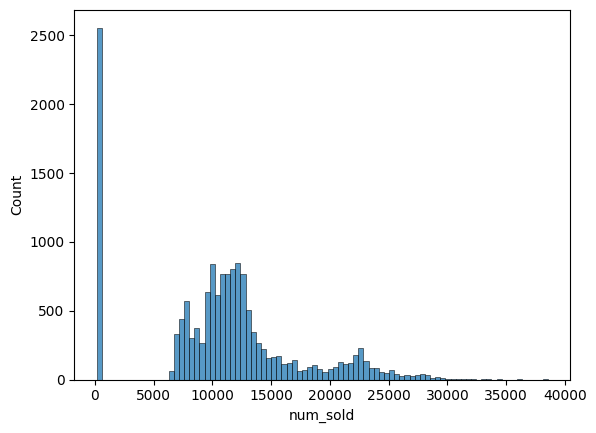

In [49]:
sns.histplot(df_train_c, x = 'num_sold')

In [51]:
df_train_c = df_train_c.join(df_dt, on = 'days')
df_test = df_test.join(df_dt, on = 'days')

## ML Pilot

In [65]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.linear_model import LogisticRegression

def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size = validation_fraction, stratify=x['md'])

config = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index = df.index),
    'score_func': lambda df, prds: r2_score(df[target].sort_index(), prds.sort_index()),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'sp_y': 'md',
    'y': 'num_sold',
    'target_func': lambda a, b: np.log(b),
    'target_invfunc': lambda b: np.exp(b)
}

ss = StratifiedShuffleSplit(n_splits = 1, train_size = 0.7, random_state = 123)

cb_adapter = sgml.CBAdapter(cb.CatBoostRegressor)
lr_adapter = sgml.SklearnAdapter(LinearRegression)
lgb_adapter = sgml.LGBMAdapter(lgb.LGBMRegressor)
xgb_adapter = sgml.XGBAdapter(xgb.XGBRegressor)

In [83]:
hparams = {
    'model_params': {},
    'X_mm': ['days'],
    'X_num': ['c1', 's1', 'c2', 's2'],
    'X_ohe': ['md', 'weekday', 'country', 'y_8'], 'ohe': {'drop': 'first'}
}
result = sgml.cv(df_train_c, ss, hparams, config, lr_adapter, result_proc = sgml.lr_learning_result)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

([0.9716870038089741], [0.9739016216533336])

In [81]:
hparams = {
    'model_params': {'n_estimators': 1500, 'learning_rate': 0.1},
    'X_num': ['c1', 's1', 'c2', 's2'],
    'X_cat': ['md', 'weekday', 'country', 'y_8']
}
result = sc.cache_result(
    'lgb_pilot', lambda : sgml.cv(df_train_c, ss, hparams, config, lgb_adapter), rerun = 0
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

([0.9853277825959562], [0.9972698017839231])

In [82]:
hparams = {
    'model_params': {'n_estimators': 1500, 'learning_rate': 0.1},
    'X_num': ['c1', 's1', 'c2', 's2'],
    'X_ohe': ['md', 'weekday', 'country', 'y_8'], 'ohe': {'drop': 'if_binary'}
}
result = sc.cache_result(
    'xgb_pilot', lambda : sgml.cv(df_train_c, ss, hparams, config, xgb_adapter), rerun = 0
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

([0.9838331937789917], [0.9951622486114502])

In [118]:
hparams = {
    'model_params': {'n_estimators': 1500, 'learning_rate': 0.1},
    'X_num': ['c1', 's1', 'c2', 's2'],
    'X_ohe': ['md', 'weekday', 'country', 'y_8'], 'ohe': {'drop': 'if_binary', 'sparse_output': False}
}
result = sc.cache_result(
    'cb_pilot', lambda : sgml.cv(df_train_c, ss, hparams, config, cb_adapter), rerun = 0
)
result['valid_scores'], result['train_scores']

([0.9882231101454206], [0.991856106837399])

In [119]:
hparams = {
    'model_params': {'n_estimators': 1500, 'learning_rate': 0.1},
    'X_num': ['c1', 's1', 'c2', 's2'],
    'X_cat': ['md', 'weekday', 'country']
}
result_lgb = sgml.train(df_train_c, hparams, config, lgb_adapter)

Round:   0%|          | 0/1500 [00:00<?, ?it/s]

In [128]:
(df_test['sp_ratio'] * np.exp(make_pipeline(result_lgb[0]['preprocessor'], result_lgb[0]['model']).predict(df_test[result_lgb[1]]))).rename('num_sold')\
    .to_frame().to_csv(os.path.join('result', 'submission7.csv'))

In [125]:
df_train.join(
    df_train_c.join(
        result['valid_prd'].rename('num_sold_prd'), how = 'inner'
    ).set_index(['country', 'days'])['num_sold_prd'], how = 'inner', on = ['country', 'days']
).pipe(
    lambda x: mean_absolute_percentage_error(x['num_sold'], x['sp_ratio'] * x['num_sold_prd'])
)

0.07175594903253943

In [ ]:
df_train = df_train.join(df_dt, on = 'date')
df_test = df_test.join(df_dt, on = 'date')

In [115]:
df_train.to_parquet(os.path.join('data', 'train.parquet'))
df_test.to_parquet(os.path.join('data', 'test.parquet'))
df_train_c.to_parquet(os.path.join('data', 'train_c.parquet'))

# Directly

In [102]:
config2 = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index = df.index),
    'score_func': lambda df, prds: mean_absolute_percentage_error(df[target].sort_index(), prds.sort_index()),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'sp_y': 'md',
    'y': 'num_sold',
    'target_func': lambda a, b: np.log(b),
    'target_invfunc': lambda b: np.exp(b)
}

In [105]:
hparams = {
    'model_params': {},
    'X_mm': ['days'],
    'X_num': ['c1', 's1', 'c2', 's2'],
    'X_ohe': ['md', 'weekday', 'country', 'y_8', 'store', 'product'], 'ohe': {'drop': 'first'}
}
result = sgml.cv(df_train, ss, hparams, config2, lr_adapter, result_proc = sgml.lr_learning_result)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

([0.11425708984806618], [0.11407745336591196])

In [112]:
hparams = {
    'model_params': {'n_estimators': 3000, 'learning_rate': 0.1},
    'X_num': ['c1', 's1', 'c2', 's2'],
    'X_cat': ['md', 'weekday', 'country', 'y_8', 'store', 'product']
}
result = sc.cache_result(
    'cb_pilot2', lambda : sgml.cv(df_train, ss, hparams, config2, cb_adapter), rerun =1
)
result['valid_scores'], result['train_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/3000 [00:00<?, ?it/s]

([0.04887108928041132], [0.04790013272064632])